In [17]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /Users/andrin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/andrin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
articles_df = pd.read_csv("NewsSentimentScored.csv")
articles_df = articles_df.dropna(subset=['SENTIMENT'])
articles_df['TEXT'] = articles_df['TEXT'].str.casefold()
articles_df['FILTER_TEXT'] = ''


In [19]:
hitword_dict = {"Elon Musk": ["elon","musk","elon musk","twitter ceo","x ceo","tesla ceo","paypal ceo","paypal founder"]}

for i in range(len(articles_df['TEXT'])):

    text = articles_df.iloc[i]['TEXT']

    phrases = tokenizer.tokenize(text)

    bank_phrases = []

    potential_names = hitword_dict["Elon Musk"]

    for phrase in phrases:

        for name in potential_names:
            if name in phrase:
                bank_phrases.append(phrase)

    new_text = " ".join(bank_phrases)

    articles_df.at[i,'FILTER_TEXT'] = new_text

In [20]:

def preprocess_text(text):
    if isinstance(text, str): 
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))

        tokens = word_tokenize(text)

        stop_words = set(stopwords.words('english'))

        tokens = [word for word in tokens if word not in stop_words]

        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        processed_text = ' '.join(tokens)

        return processed_text
    else:
        return pd.NA

X = articles_df['FILTER_TEXT'].apply(preprocess_text)

y_values = articles_df['SENTIMENT']

thresholds = [-1, -0.3333, 0.3333, 1]

y = np.digitize(y_values, thresholds) - 2


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Handling missing values in the text column
X.fillna('', inplace=True)  # Replace NaNs with an empty string or any other suitable value

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initializing Logistic Regression model for multiclass and training
log_reg_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_reg_model.fit(X_train_tfidf, y_train)

# Predicting on test set
y_pred = log_reg_model.predict(X_test_tfidf)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

mse


0.7602367146870703


0.2652280471038317

In [22]:

y_pred_prob = log_reg_model.predict_proba(tfidf_vectorizer.transform(X))

y_pred = []

for entry in y_pred_prob:
    y_p = -1 * entry[0] + 1 * entry[2]
    y_pred.append(y_p)

articles_df['LOGISTIC_SENTIMENT'] = y_pred

0.017671043094470144


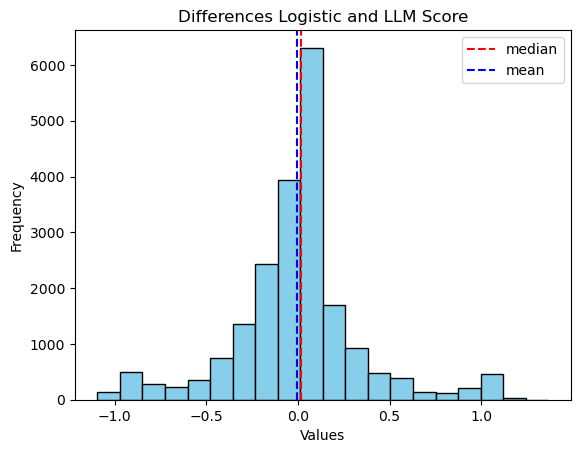

In [23]:
articles_df['Diff_to_LLM'] = articles_df['SENTIMENT'] -  articles_df['LOGISTIC_SENTIMENT']

median = np.median(articles_df['Diff_to_LLM'].dropna())
print(median)
mean = np.mean(articles_df['Diff_to_LLM'].dropna())

plt.hist(articles_df['Diff_to_LLM'] , bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.axvline( median, color='red', linestyle='dashed', linewidth=1.5, label = "median")
plt.axvline( mean, color='blue', linestyle='dashed', linewidth=1.5, label = "mean")
plt.title('Differences Logistic and LLM Score')
plt.legend()
plt.show()


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initializing SVM model and training
svm_model = SVC(kernel='rbf', probability=True)  # You can choose different kernels (e.g., 'rbf', 'poly') based on your data
svm_model.fit(X_train_tfidf, y_train)

# Predicting on test set
y_pred = svm_model.predict(X_test_tfidf)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.7595


In [29]:
y_pred_prob_svm = svm_model.predict_proba(tfidf_vectorizer.transform(X))

y_pred_svm = []

for entry in y_pred_prob_svm:
    y_p = -1 * entry[0] + 1 * entry[2]
    y_pred_svm.append(y_p)

articles_df['SVM_SENTIMENT'] = y_pred_svm

In [32]:
mse = mean_squared_error(y_test, y_pred)

mse

0.26630402295415145

In [30]:
EXPORT_DF =   articles_df
cols_to_keep = ['DATE','SENTIMENT','SVM_SENTIMENT','LOGISTIC_SENTIMENT']
EXPORT_DF = EXPORT_DF[cols_to_keep]

EXPORT_DF.to_csv("LOG_AND_SVM_SENTIMENT.csv")

0.030824740573408622


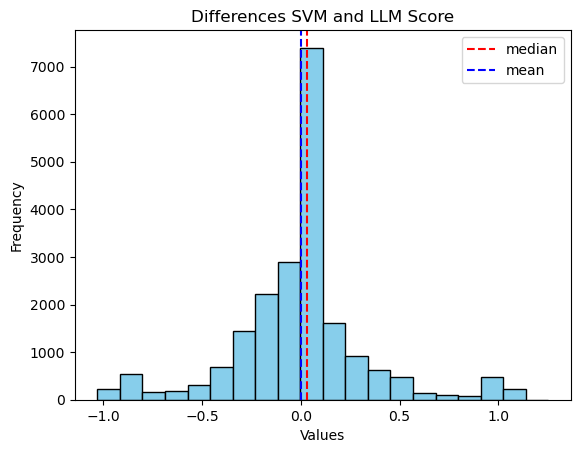

In [69]:
articles_df['Diff_to_LLM_SVM'] = articles_df['SENTIMENT'] -  articles_df['SVM_SENTIMENT']

median = np.median(articles_df['Diff_to_LLM_SVM'].dropna())
print(median)
mean = np.mean(articles_df['Diff_to_LLM_SVM'].dropna())

plt.hist(articles_df['Diff_to_LLM_SVM'] , bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.axvline( median, color='red', linestyle='dashed', linewidth=1.5, label = "median")
plt.axvline( mean, color='blue', linestyle='dashed', linewidth=1.5, label = "mean")
plt.title('Differences SVM and LLM Score')
plt.legend()
plt.show()


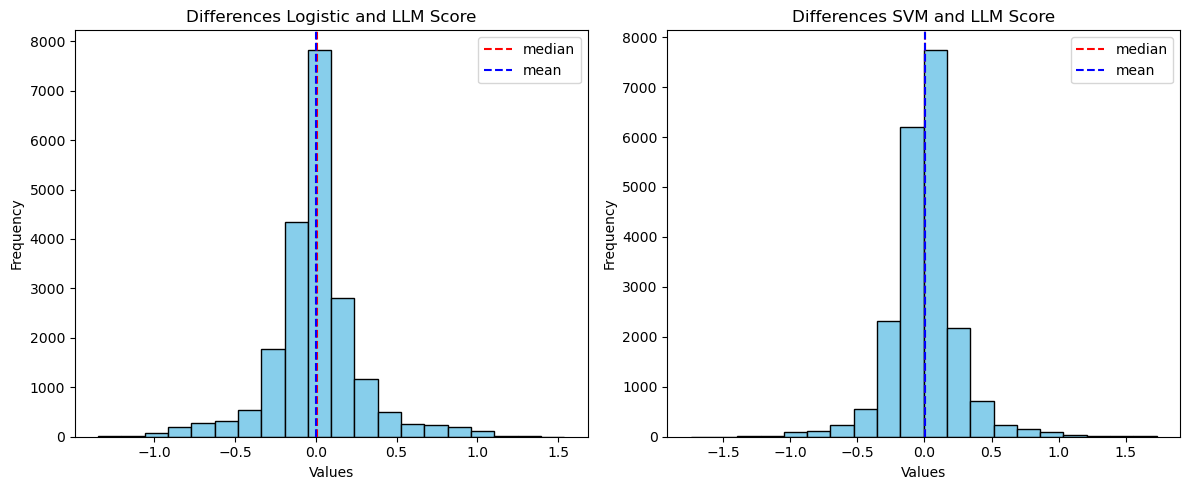

In [16]:

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].hist(articles_df['Diff_to_LLM'] , bins=20, color='skyblue', edgecolor='black') 
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
axes[0].axvline( median, color='red', linestyle='dashed', linewidth=1.5, label = "median")
axes[0].axvline( mean, color='blue', linestyle='dashed', linewidth=1.5, label = "mean")
axes[0].set_title('Differences Logistic and LLM Score')
axes[0].legend()

axes[1].hist(articles_df['Diff_to_LLM_SVM'] , bins=20, color='skyblue', edgecolor='black') 
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
axes[1].axvline( median, color='red', linestyle='dashed', linewidth=1.5, label = "median")
axes[1].axvline( mean, color='blue', linestyle='dashed', linewidth=1.5, label = "mean")
axes[1].set_title('Differences SVM and LLM Score')
axes[1].legend()


plt.tight_layout()  
plt.show()

/var/folders/12/3jbr72wx715gstyblw8wb9zh0000gn/T/ipykernel_84328/2579130075.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DATE'] = pd.to_datetime(filtered_data['DATE'], format='%d-%m-%Y')


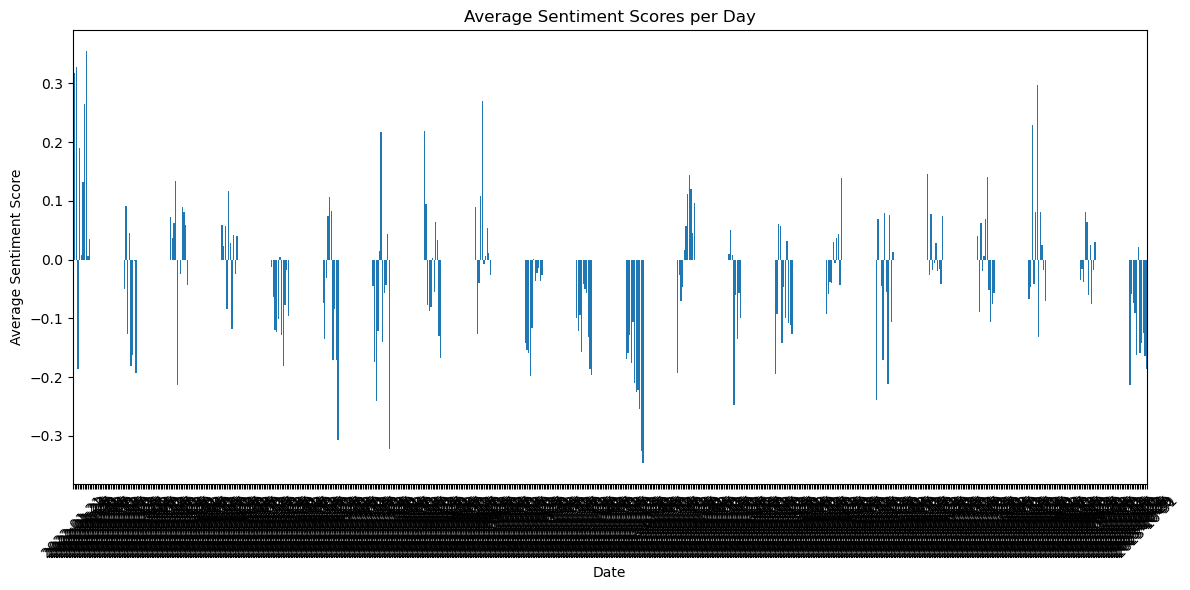

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming articles_df is your DataFrame with columns 'DATE' and 'SENTIMENT'
filtered_data = articles_df[(articles_df['DATE'] >= '2022-01-01')]

# Assuming filtered_data is your DataFrame with columns 'DATE' and 'SENTIMENT'

# Convert 'DATE' column to datetime format
filtered_data['DATE'] = pd.to_datetime(filtered_data['DATE'], format='%d-%m-%Y')

# Grouping data by date and calculating the mean sentiment score for each day
grouped_data = filtered_data.groupby('DATE')['SENTIMENT'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))

plt.bar(grouped_data['DATE'], grouped_data['SENTIMENT'], width=0.8, align='center')

plt.title('Average Sentiment Scores per Day')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')

# Setting x-axis ticks to show each day or a suitable interval
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())  # Set ticks for each day
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Adjust date format as needed
plt.xlim(filtered_data['DATE'].min(), filtered_data['DATE'].max())

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()





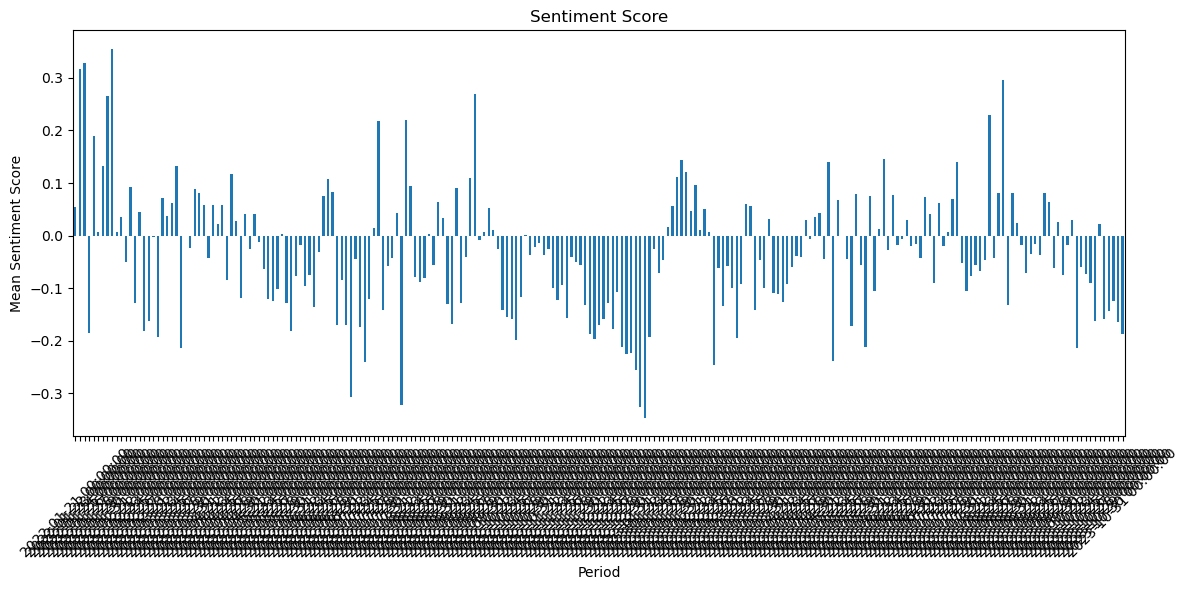

In [46]:
filtered_data['YEAR_MONTH'] = articles_df['DATE'].str[6:] + "-" + articles_df['DATE'].str[3:5]

filtered_data = filtered_data[(filtered_data['DATE'] >= '2022-01-01')]

#generate mean of sentiment_score by period
dfg = filtered_data.groupby(['DATE'])['SENTIMENT'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(12, 6))

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()




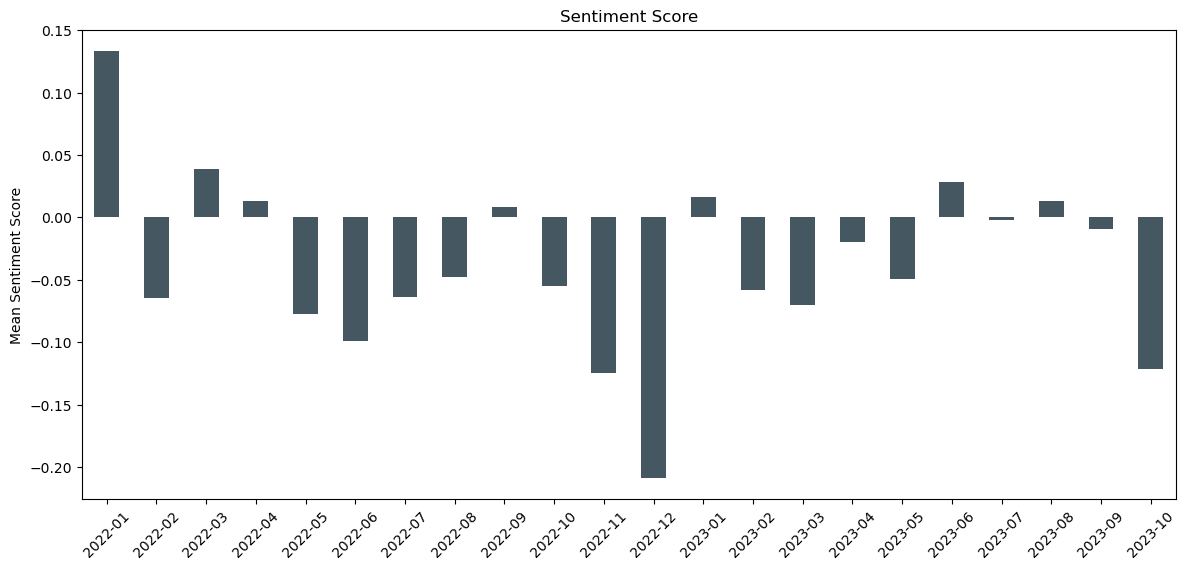

In [ ]:
import matplotlib.pyplot as plt

# Your existing code
filtered_data['YEAR_MONTH'] = articles_df['DATE'].str[6:] + "-" + articles_df['DATE'].str[3:5]
filtered_data = filtered_data[(filtered_data['DATE'] >= '2022-01-01')]
dfg = filtered_data.groupby(['DATE'])['SENTIMENT'].mean()

# Create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(12, 6), color="#455761")

plt.xticks(range(0, len(dfg), 1), dfg.index)  # Setting ticks for every month
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel('')
plt.show()


/var/folders/12/3jbr72wx715gstyblw8wb9zh0000gn/T/ipykernel_84328/2428945567.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[(youtube['DATE'] >= '2022-01-01')]


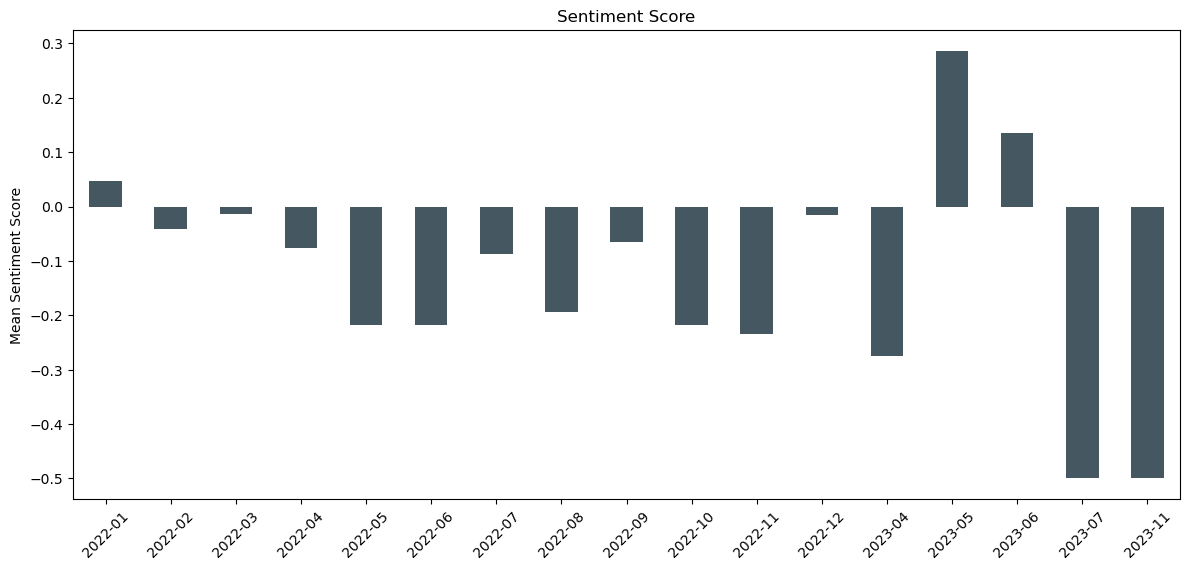

In [53]:
youtube = pd.read_csv("YoutubeSentiment.csv")

# Your existing code
filtered_data['YEAR_MONTH'] = youtube['DATE'].str[6:] + "-" + youtube['DATE'].str[3:5]
filtered_data = filtered_data[(youtube['DATE'] >= '2022-01-01')]
dfg = filtered_data.groupby(['YEAR_MONTH'])['SENTIMENT'].mean()

# Create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(12, 6), color="#455761")

plt.xticks(range(0, len(dfg), 1), dfg.index)  # Setting ticks for every month
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel('')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generating sample data
dates = pd.date_range('2023-01-01', '2023-12-31')
values = np.random.rand(len(dates))

# Creating a DataFrame
data = pd.DataFrame({'Date': dates, 'Value': values})

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Value'])

# Setting x-axis ticks to show every 10th tick
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [38]:
print(filtered_data)

            DATE           OUTLET  \
2     2023-10-22             bing   
4     2023-10-24             bing   
60    2023-10-26             bing   
61    2023-10-24             bing   
83    2023-10-31             bing   
...          ...              ...   
20882 2023-10-27  washington post   
20883 2023-10-28  washington post   
20884 2023-10-28  washington post   
20885 2023-10-29  washington post   
20886 2023-10-31  washington post   

                                                  AUTHOR  \
2                                             Daily Mail   
4                                                  Yahoo   
60                                         Yahoo News UK   
61                                                   NME   
83                                            The Mirror   
...                                                  ...   
20882                                     By Joseph Menn   
20883                                       Chico Harlan   
20884  Will Ore